### MINST DIGIT Classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid

plt.style.use('ggplot')

importing data

In [3]:
import deeplake
ds = deeplake.load("hub://activeloop/mnist-train")

|

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/mnist-train



-

hub://activeloop/mnist-train loaded successfully.



In [46]:
X = tf.identity(ds['images'])
y = tf.identity(ds['labels'])

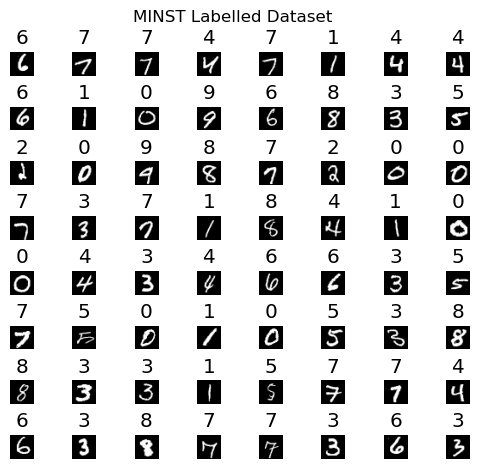

In [47]:
fig,ax = plt.subplots(8,8, figsize=(5,5))
m = X.shape[0]
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]

for i , ax in enumerate(ax.flat):
    index = np.random.randint(m)
    img = X[index].numpy()
    label = y[index].numpy()
    
    ax.imshow(img,cmap='gray')
    ax.set_title(label[0])
    ax.set_axis_off()
    
    fig.suptitle('MINST Labelled Dataset')

### Data Prepping
#### - Flattening the images.
#### - Scaling it

In [48]:
X = tf.reshape(X, (60000, 28 * 28)) ## flattening 
X = tf.cast(X, tf.float32) / 255.0  # Scale to [0, 1]

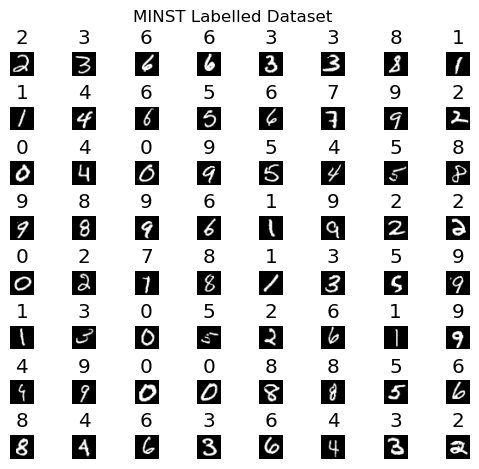

In [51]:
fig,ax = plt.subplots(8,8, figsize=(5,5))
m = X.shape[0]
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]

for i , ax in enumerate(ax.flat):
    index = np.random.randint(m)
    img = X[index].numpy().reshape(28,28)
    label = y[index].numpy()
    
    ax.imshow(img,cmap='gray')
    ax.set_title(label[0])
    ax.set_axis_off()
    
    fig.suptitle('MINST Labelled Dataset')

### BUILDING NN

In [53]:
tf.random.set_seed(1234)
model = Sequential([
    Dense(units=25, activation='relu',input_shape=(28*28,)),
    Dense(units=15, activation='relu'),
    Dense(units=10, activation='linear')
])

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 25)                19625     
                                                                 
 dense_4 (Dense)             (None, 15)                390       
                                                                 
 dense_5 (Dense)             (None, 10)                160       
                                                                 
Total params: 20175 (78.81 KB)
Trainable params: 20175 (78.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [58]:
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
)

In [60]:
model.fit(
    X,
    y,
    epochs=40
)

Epoch 1/40

1875/1875 [==============================] - 4s 2ms/step - loss: 0.3904
Epoch 2/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1942
Epoch 3/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1604
Epoch 4/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1395
Epoch 5/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1258
Epoch 6/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1148
Epoch 7/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1061
Epoch 8/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1001
Epoch 9/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0942
Epoch 10/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0882
Epoch 11/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0843
Epoch 12/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0798


In [61]:
ds = deeplake.load("hub://activeloop/mnist-test")
X_test = tf.identity(ds['images'])
y_test = tf.identity(ds['labels'])

/

Opening dataset in read-only mode as you don't have write permissions.


This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/mnist-test



|

hub://activeloop/mnist-test loaded successfully.



In [110]:
def predict(img):
    """Predicts the digits present inside the image
    Input:
    img : Tensor Grayscale image array of shape 28x28
    
    Output:
    label: predicted integer value of the image
    """
    
    
    x = tf.reshape(img, (28 * 28,)) ## flattening 
    x = tf.expand_dims(x, axis=0)
    x = tf.cast(x, tf.float32) / 255.0  # Scale to [0, 1]
    
    prediction = model.predict(x,verbose=0)
    prediction = tf.nn.softmax(prediction)
    
    label = np.argmax(prediction)
    
    return label
    

In [111]:
m = X_test.shape[0]
yhat = np.zeros(m)

for i in range(m):
    pred = predict(X_test[i])
    yhat[i] = pred
    
print('DONE!')

DONE!


In [131]:
y_test_flat = tf.squeeze(y_test)
accuracy = tf.reduce_mean(tf.cast(tf.equal(yhat, y_test_flat), tf.float32))

In [132]:
accuracy

<tf.Tensor: shape=(), dtype=float32, numpy=0.9625>

The model exhibit 0.9625 accuracy

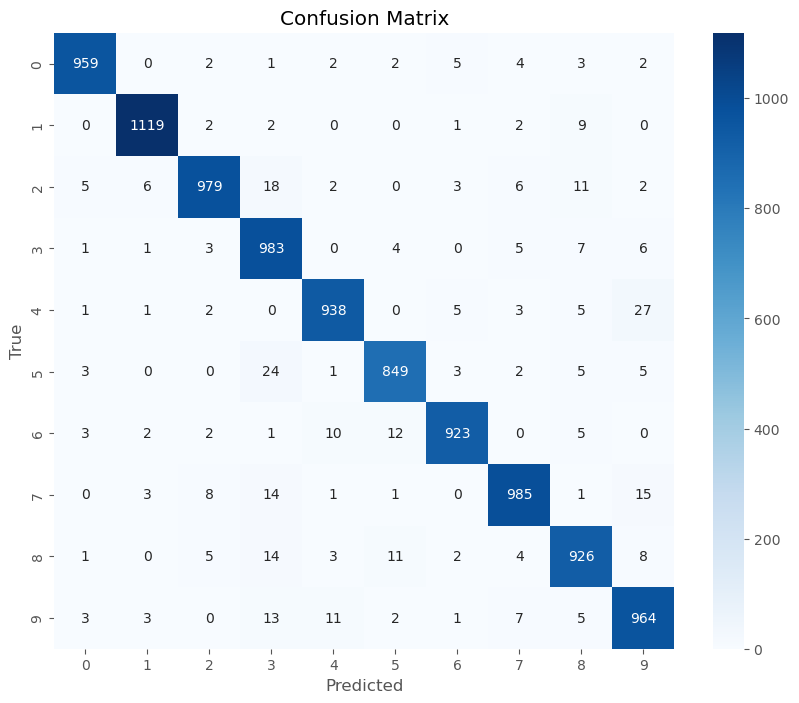

In [139]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_flat,yhat)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [143]:
model.save('digit_classifier.keras')